# <center>Проект 4 </br>Задача классификации</center>

## Оглавление

* [Импорт библиотек](#Импорт-библиотек)
* [Загрузка данных](#Загрузка-данных)
* [1 Первичная обработка данных](#1-Первичная-обработка-данных)
    * [1.1 Обработка пропусков](#1.1-Обработка-пропусков)
    * [1.2 Анализ выбросов](#1.2-Анализ-выбросов)
* [2 Разведывательный анализ](#2-Разведывательный-анализ)
* [3 Отбор и преобразование признаков](#3-Отбор-и-преобразование-признаков)
    * [3.1 Кодирование признаков](#3.1-Кодирование-признаков)
    * [3.2 Проверка на мультиколлинеарность](#3.2-Проверка-на-мультиколлинеарность)
    * [3.3 Обработка целевой переменной](#3.3-Обработка-целевой-переменной)
    * [3.4 Нормализация данных](#3.4-Нормализация-данных)
* [4 Решение задачи классификации: логистическая регрессия и решающие деревья](#4-Решение-задачи-классификации:-логистическая-регрессия-и-решающие-деревья)
* [5 Решение задачи классификации: ансамбли моделей и построение прогноза](#5-Решение-задачи-классификации:-ансамбли-моделей-и-построение-прогноза)
    * [5.1 Дополнительная оптимизация. Optuna](#5.1-Дополнительная-оптимизация.-Optuna)

К сожалению, ссылки внутри ноутбука не работают на GitHub. Необходимо либо скачать ноутбук, либо перейти по [ссылке](https://nbviewer.org/github/DS-Makovetskiy/DS/blob/main/Project_4_Classification_task/Project_4_Classification_task.ipynb).

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import optuna

from data_preprocessing import outliers_iqr_mf

import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 42

## Загрузка данных

**Данные о клиентах банка:**
* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

**Данные, связанные с последним контактом:**
* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

**Прочие признаки:**
* campaign (количество контактов с этим клиентом в течение текущей кампании);
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

**Целевой признак:**
* deposit.

In [3]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes


## 1 Первичная обработка данных

### 1.1 Обработка пропусков

Проверим, есть ли в данных пропущенные значения

In [4]:
na_count = df.isna().sum()
na_count[na_count > 0]

balance    25
dtype: int64

Проверим, как еще могут быть закодированы пропуски (неизвестные значения).

In [5]:
display(df['job'].unique())

display(df['education'].unique())

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

array(['secondary', 'tertiary', 'primary', 'unknown'], dtype=object)

*"unknown"* так же означает неизвестные, пропущенные значения

В признаке **balance** содержится лишняя запятая и знак доллара. По этой причине этот признак не считывается как число. Обработаем данные этого признака так, чтобы он был преобразован в тип float.

In [6]:
df['balance'] = df['balance'].apply(lambda x: x if x is np.NAN else x.replace(' ', '').split(',')[0].split('$')[0]).astype('float')

df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes


Теперь обработаем проуспки в этом признаке. Поскольку пропусков неимного, заменим их медианным значением.

In [7]:
med_balance   = df['balance'].median()
df['balance'] = df['balance'].fillna(med_balance)

# проверим количество пропусков в данных
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

Ранее мы выяснили, что в признаке job есть пропущенные значения, которые не отображаются как пропуски в явном виде. 

Заменим все пропущенные значения в признаке **job** на модальные. То же самое сделайем с признаком **education**.

In [8]:
print('Список уникальных значений признака job')
display(df['job'].unique())

print('Список уникальных значений признака education')
display(df['education'].unique())

Список уникальных значений признака job


array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

Список уникальных значений признака education


array(['secondary', 'tertiary', 'primary', 'unknown'], dtype=object)

In [9]:
mc_job = df['job'].mode()[0]
mc_edu = df['education'].mode()[0]

df['job']       = df['job'].replace(['unknown'], mc_job)
df['education'] = df['education'].replace(['unknown'], mc_edu)

In [10]:
print('Список уникальных значений признака job')
display(df['job'].unique())

print('Список уникальных значений признака education')
display(df['education'].unique())

Список уникальных значений признака job


array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'self-employed', 'student'], dtype=object)

Список уникальных значений признака education


array(['secondary', 'tertiary', 'primary'], dtype=object)

### 1.2 Анализ выбросов

Изучим признак, отображающий баланс клиентов, на предмет выбросов.

Мы будем считать, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха ($Q1 - 1.5 * IQR$) , а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха. ($Q3 + 1.5 * IQR$).

Найдем эти границы, и отфильтруем значения так, чтобы выбросов в данных не осталось.

In [11]:
# удалим все выбросы для признака balance
outliers, cleaned = outliers_iqr_mf(df, 'balance')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

lower_bound: -2241, upper_bound: 4063
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


In [12]:
df = cleaned.copy()

## 2 Разведывательный анализ

Посмотрим на распределение целевой переменной и сбалансированность классов.

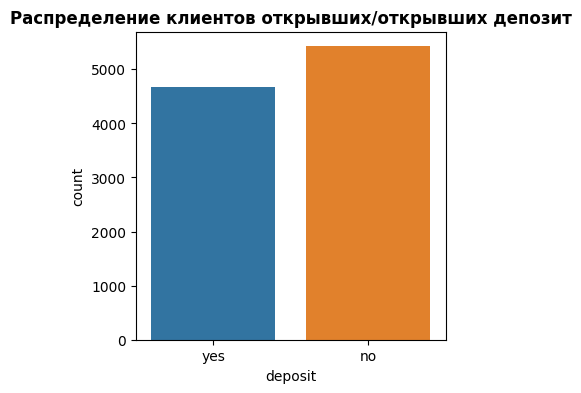

In [13]:
plt.figure(figsize=(4, 4))

sns.countplot(
    data = df,
    x    = 'deposit',
    hue  = 'deposit'
)
plt.title('Распределение клиентов открывших/открывших депозит', fontweight='bold');

Посмотрим на максимальный возраст клиента банка.

Максимальный возраст клиента банка: 95


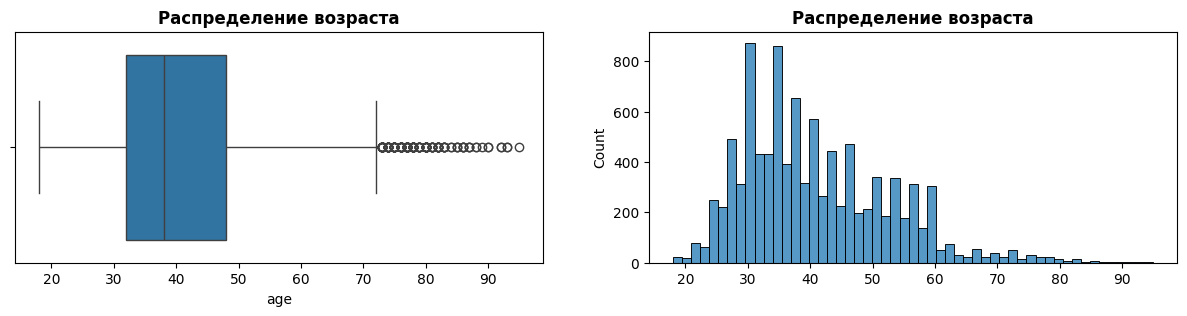

In [14]:
print(f'Максимальный возраст клиента банка: {df["age"].max()}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
sns.boxplot(df['age'], orient='h', ax=axes[0])
sns.histplot(df['age'], ax=axes[1])
axes[0].set_title('Распределение возраста', fontweight='bold')
axes[1].set_title('Распределение возраста', fontweight='bold')
axes[1].set_xlabel('');

Определим минимальную продолжительность разговора с клиентом банка в количестве секунд.

Минимальная продолжительность разговора с клиентом банка: 2


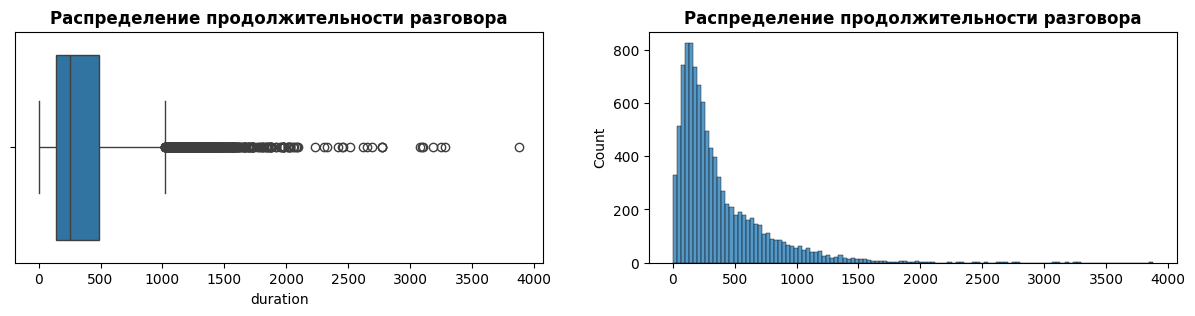

In [15]:
print(f'Минимальная продолжительность разговора с клиентом банка: {df["duration"].min()}')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
sns.boxplot(df['duration'], orient='h', ax=axes[0])
sns.histplot(df['duration'], ax=axes[1])
axes[0].set_title('Распределение продолжительности разговора', fontweight='bold')
axes[1].set_title('Распределение продолжительности разговора', fontweight='bold')
axes[1].set_xlabel('')
plt.show();

Рассмотрим описательные статистики для категориальных переменных.
* Сколько всего сфер занятости представлено среди клиентов банка?
* В каждый ли месяц проходила маркетинговая кампания?
* Какое семейное положение встречается чаще всего? 
* Какое образование встречается чаще всего? 

Количество месяцев, в которых проводилась маркетинговая кампания: 12


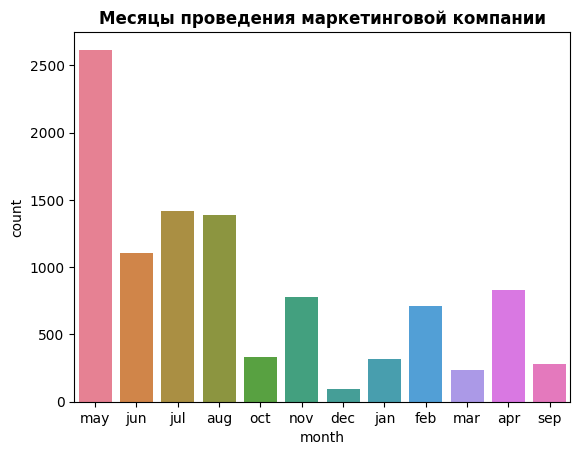

In [16]:
print(f"Количество месяцев, в которых проводилась маркетинговая кампания: {df['month'].nunique()}")

sns.countplot(
    data = df, 
    x    = 'month',
    hue  = 'month'
)
plt.title('Месяцы проведения маркетинговой компании', fontweight='bold')
plt.show();

Количество сфер занятости среди клиентов банка: 11


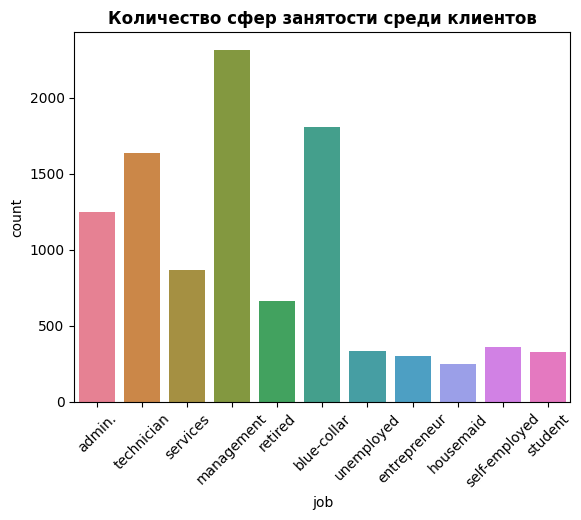

In [17]:
print(f"Количество сфер занятости среди клиентов банка: {df['job'].nunique()}")

sns.countplot(
    data = df, 
    x    = 'job',
    hue  = 'job')
plt.title('Количество сфер занятости среди клиентов', fontweight='bold')
plt.xticks(rotation=45)
plt.show();

Самое распространенное семейное положение: married


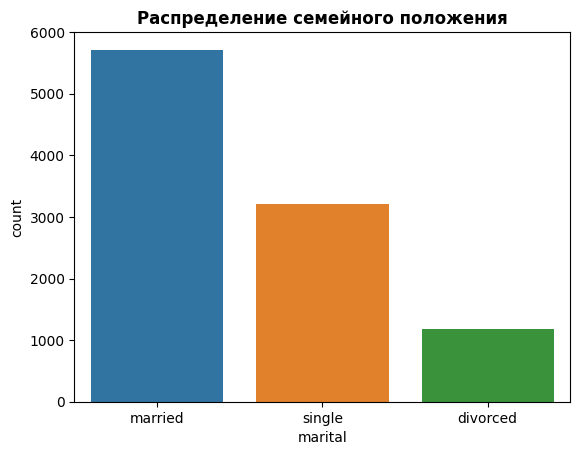

In [18]:
print(f"Самое распространенное семейное положение: {df['marital'].mode()[0]}")

sns.countplot(
    data = df, 
    x    = 'marital',
    hue  = 'marital'
)
plt.title('Распределение семейного положения', fontweight='bold')
plt.show();

Самое распространенное образование: secondary


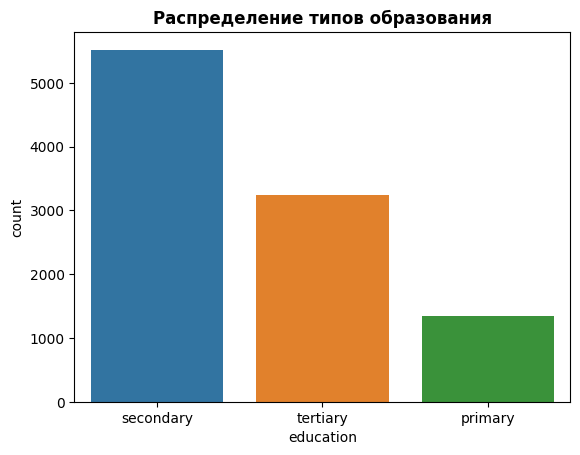

In [19]:
print(f"Самое распространенное образование: {df['education'].mode()[0]}")

sns.countplot(
    data = df, 
    x    = 'education',
    hue  = 'education'
)
plt.title('Распределение типов образования', fontweight='bold')
plt.show();

Сравним результаты текущей маркетинговой кампании и предыдущей, есть ли между ними разница. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная. Посмотрим, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

In [20]:
types = df.groupby("poutcome")['deposit'].value_counts().unstack()

types

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


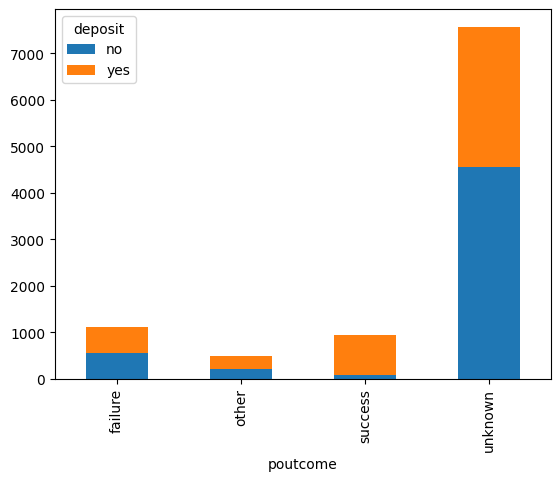

In [21]:
types.plot(kind='bar', stacked='True');

Посмотрим на зависимость результата маркетинговых кампаний от месяца.

Временные периоды, сезоны, близость к каким-то праздникам часто влияют на решение клиентов использовать определённые услуги.

In [22]:
df.groupby('month')['deposit'].value_counts(normalize=True).round(2).unstack().sort_values('no', ascending=False)

deposit,no,yes
month,,
may,0.68,0.32
jan,0.61,0.39
jul,0.59,0.41
nov,0.58,0.42
aug,0.56,0.44
jun,0.55,0.45
feb,0.46,0.54
apr,0.38,0.62
oct,0.19,0.81


В мае наблюдался самый большой процент неудач при взаимодействии в текущей маркетинговой кампании.

Посмотрим, люди какого возраста чаще открывают депозиты, а какого — реже.

Для большей наглядности, сгруппируем возраст по категориям:
* '<30';
* '30-40';
* '40-50';
* '50-60';
* '60+'.

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50


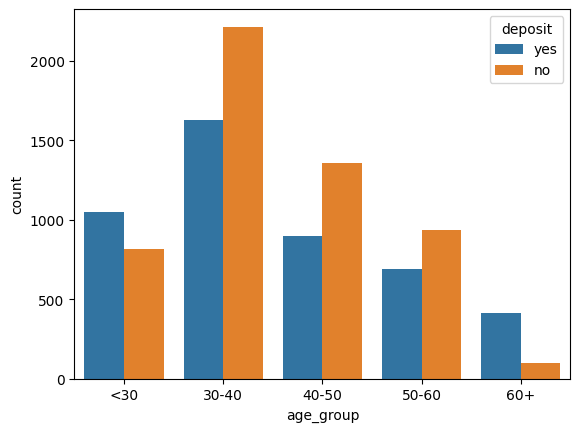

In [23]:
df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])

sns.countplot(x="age_group", hue="deposit", data=df)

df.head(3)

Как видно из графика, люди в возрасте до 30  и после 60 лет, более склонны открывать депозит, чем отказываться от предложения.

Посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:
* семейное положение;
* уровень образования;
* сфера занятости.

Количество людей, открывших и неоткрывших депозит в зависимости от семейного статуса.

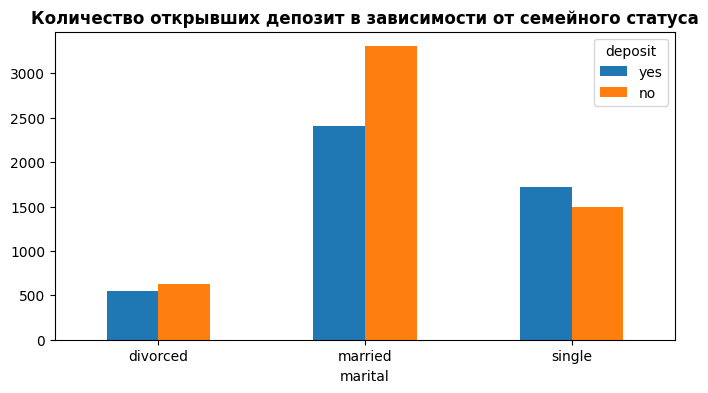

In [24]:
marital_type = df.groupby('marital')['deposit'].value_counts().unstack()

# поменяем признаки местами для сохранения порядка на графике
marital_type = marital_type[['yes', 'no']]

marital_type.plot(kind='bar', figsize=(8, 4))
plt.xticks(rotation=0)
plt.title('Количество открывших депозит в зависимости от семейного статуса', fontweight='bold');

Большинство людей относятся к группе женатых, однако именно одинокие, более склонны открывать депозит, чем отказываться.

Количество людей, открывших и неоткрывших депозит в зависимости от семейного образования.

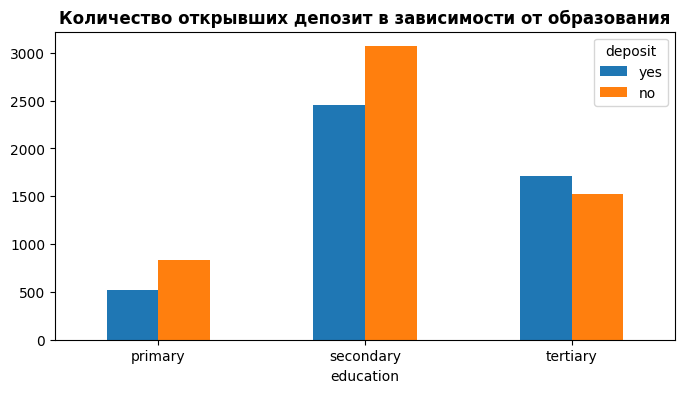

In [25]:
education_type = df.groupby('education')['deposit'].value_counts().unstack()

# поменяем признаки местами для сохранения порядка на графике
education_type = education_type[['yes', 'no']]

education_type.plot(kind='bar', figsize=(8, 4))
plt.xticks(rotation=0)
plt.title('Количество открывших депозит в зависимости от образования', fontweight='bold');

Большинство людей имеют среднее образование, но только люди с высшим образованием более склонны открывать депозит, чем отказываться.

Количество людей, открывших и неоткрывших депозит в зависимости от вида профессиональной занятости.

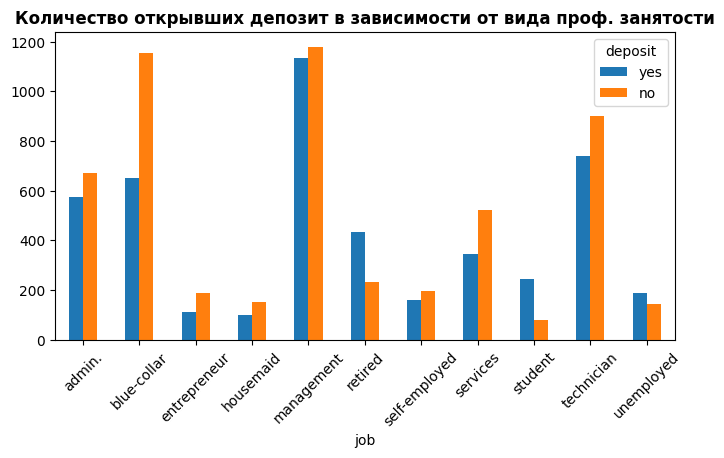

In [26]:
job_type = df.groupby('job')['deposit'].value_counts().unstack()

# поменяем признаки местами для сохранения порядка на графике
job_type = job_type[['yes', 'no']]

job_type.plot(kind='bar', figsize=(8, 4))
plt.xticks(rotation=45)
plt.title('Количество открывших депозит в зависимости от вида проф. занятости', fontweight='bold');

Большинство людей представлены рабочим классом, управленческим составом и техническими специалистами. Однако безработные, студенты и пенсионеры более склонны открывать депозит, чем отказываться.

Посмотрим на пересечения категорий. Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования?

Разделим таблицу на две части: для тех, кто открыл депозит, и для тех, кто не открыл. Для каждой части построим сводную диаграмму по уровню образования и семейному положению. Результаты отобразим в виде тепловых карт.

In [27]:
first_cat  = df[df['deposit'] == 'yes']
second_cat = df[df['deposit'] == 'no']

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


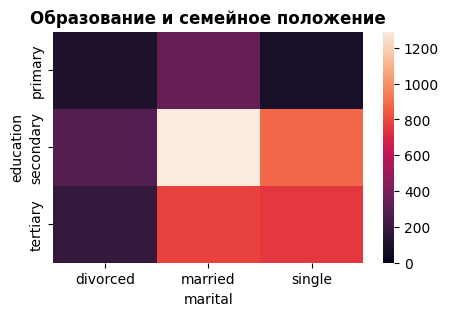

In [28]:
pivot_fc = pd.crosstab(first_cat['education'], first_cat['marital'])

display(pivot_fc)

plt.figure(figsize=(5, 3))
sns.heatmap(pivot_fc, vmin=0)
plt.title('Образование и семейное положение', fontweight='bold');
plt.show();

Из тех, кто открыл депозит, самым многочисленным является пересечение таких категорий как женатые со средним образованием.

marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


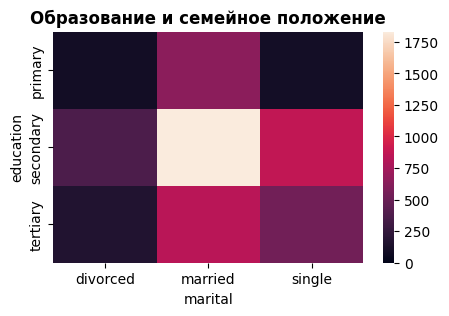

In [29]:
pivot_sc = pd.crosstab(second_cat['education'], second_cat['marital'])

display(pivot_sc)

plt.figure(figsize=(5, 3))
sns.heatmap(pivot_sc, vmin=0)
plt.title('Образование и семейное положение', fontweight='bold');
plt.show();

Из тех, кто отказался, самым многочисленным является пересечение таких же категорий, женатые со средним образованием. 

Дело в том, что в этих группах сосредоточено большинство клиентов из всего набора данных.

## 3 Отбор и преобразование признаков

### 3.1 Кодирование признаков

Начнём с обработки категориального порядкового признака, который отвечает за уровень образования (**education**) при помощи метода LabelEncoder.

In [30]:
le_edu          = LabelEncoder()
df['education'] = le_edu.fit_transform(df['education'])

df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50


Ранее мы создали порядковую переменную для возраста (**age_group**). Обработаем её по такому же принципу, чтобы её можно было использовать при обучении модели.

In [31]:
le_age          = LabelEncoder()
df["age_group"] = le_age.fit_transform(df["age_group"])

df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1


Признак **deposit** преобразуем в виде бинарной переменной, в представлении из нулей и единиц при помощи LabelBinarizer.

In [32]:
lb            = LabelBinarizer()
df['deposit'] = lb.fit_transform(df['deposit'])

df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,1,1


Сделаем то же самое для других бинарных переменных, которых у нас три:
* default;
* housing;
* loan.

Все три мы будем модифицировать ровно так же: для слова yes мы возьмём в качестве значения 1, а для no — 0.

In [33]:
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan']    = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1


Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:
* job;
* marital;
* contact;
* month;
* poutcome.

Создадим для них dummy-переменные и добавим их в набор данных.

In [34]:
categorial_features = ['job', 'marital', 'contact', 'month', 'poutcome']

df1 = pd.get_dummies(df[categorial_features])
df  = pd.concat([df,df1], axis=1)

df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,...,False,False,True,False,False,False,False,False,False,True
1,56,admin.,married,1,0,45.0,0,0,unknown,5,...,False,False,True,False,False,False,False,False,False,True
2,41,technician,married,1,0,1270.0,1,0,unknown,5,...,False,False,True,False,False,False,False,False,False,True


Удалим исходные, категориальные признаки

In [35]:
df = df.drop(categorial_features, axis=1)
df.head(3)

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,False,False,True,False,False,False,False,False,False,True
1,56,1,0,45.0,0,0,5,1467,1,-1,...,False,False,True,False,False,False,False,False,False,True
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,False,False,True,False,False,False,False,False,False,True


### 3.2 Проверка на мультиколлинеарность

Теперь давайте оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

Для этого построим матрицу корреляций и дополним её тепловой картой, отражающей результат.

А так же построим столбчатую диаграмму для ранжированных коэффициентов корреляции.

In [36]:
corr = df.corr()
corr = corr[np.abs(corr) >= 0.7]

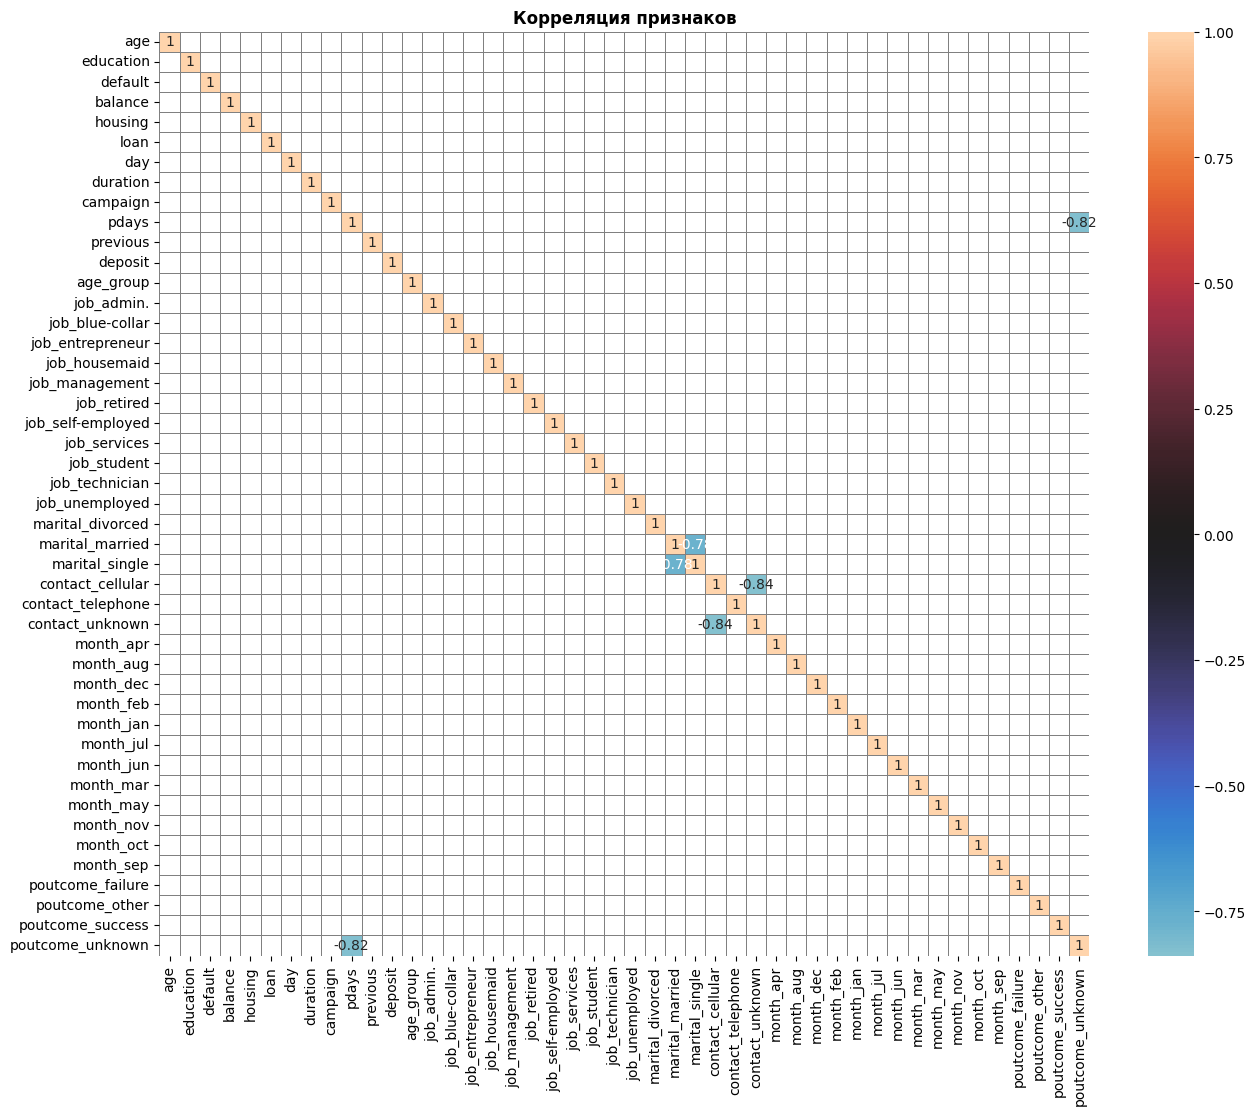

In [37]:
plt.subplots(figsize=(15,12))
heatmap = sns.heatmap(
    corr, 
    annot      = True, 
    linewidths = 0.5, 
    center     = 0, 
    linecolor  = 'grey')
heatmap.set_title('Корреляция признаков', fontweight='bold');

Отобразим признаки, в наибольшей степени коррелирующие с целевой переменной, по убыванию силы линейной взаимосвязи.

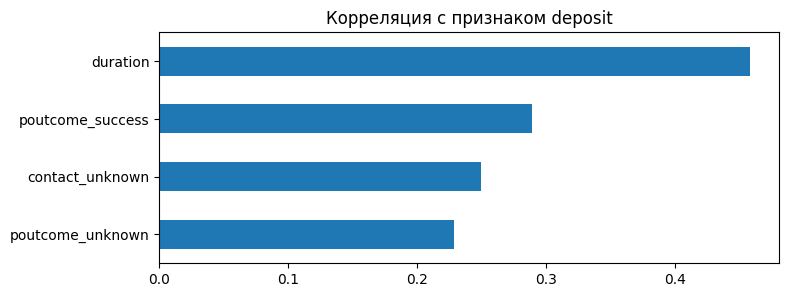

In [38]:
corr = df.corr()

plt.subplots(figsize=(8,3))
corr["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Корреляция с признаком deposit")
plt.show()

### 3.3 Обработка целевой переменной

Разбиение данных на тренировочную и тестовую выборки, с сохранением соотношения признаков.

In [39]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RANDOM_STATE, test_size=0.33)

Посмотрим на все признаки и оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберем 15 признаков, наилучшим образом подходящих для использования в задаче.

In [40]:
skb = SelectKBest(score_func=f_classif, k=15)

skb.fit_transform(X_train, y_train)

best_columns = list(skb.get_feature_names_out())

print(f'Список наиболее значимых признаков:\n{best_columns}')

Список наиболее значимых признаков:
['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous', 'age_group', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']


Оставим только занчимые признаки

In [41]:
X_train = X_train[best_columns]
X_test  = X_test[best_columns]

### 3.4 Нормализация данных

Нормализуем данные при помощи MinMaxScaler.

In [42]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train)

X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled  = mm_scaler.transform(X_test)

# 4 Решение задачи классификации: логистическая регрессия и решающие деревья

Для начала реализуем самый простой алгоритм - логистическую регрессию. В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

In [43]:
log_reg = LogisticRegression(solver='sag', random_state=RANDOM_STATE, max_iter=1000)

log_reg.fit(X_train_scaled, y_train)

y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred  = log_reg.predict(X_test_scaled)

print(f'LR Accuracy на тренировочной выборке: {round(accuracy_score(y_train_pred, y_train), 2)}')
print(f'LR Accuracy на тестовой выборке: {round(accuracy_score(y_test_pred, y_test), 2)}')

LR Accuracy на тренировочной выборке: 0.82
LR Accuracy на тестовой выборке: 0.81


Простой алгоритм обучен. Теперь давайте обучим ещё один алгоритм - решающие деревья.

In [44]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE, max_depth=6)

dt.fit(X_train_scaled, y_train)

y_train_pred = dt.predict(X_train_scaled)
y_test_pred  = dt.predict(X_test_scaled)

print(f'DT Accuracy на тренировочной выборке: {round(accuracy_score(y_train_pred, y_train), 2)}')
print(f'DT Accuracy на тестовой выборке: {round(accuracy_score(y_test_pred, y_test), 2)}')

DT Accuracy на тренировочной выборке: 0.82
DT Accuracy на тестовой выборке: 0.81


Выполним поиск оптимальных гиперпараметров модели при помощи GridSearch, перебрав следующие параметры:
* 'min_samples_split' : [2, 5, 7, 10]
* 'max_depth'         : [3, 5, 7]

In [45]:
parameters = {
    'min_samples_split': [2, 5, 7, 10], 
    'max_depth': [3, 5, 7]
}

model_cv = GridSearchCV(
    DecisionTreeClassifier(), 
    param_grid         = parameters, 
    cv                 = 3, 
    scoring            = ('f1'), 
    return_train_score = True)

model_cv.fit(X_train_scaled, y_train)

y_train_pred = model_cv.predict(X_train_scaled)
y_test_pred  = model_cv.predict(X_test_scaled)

print(f'DT Accuracy на тестовой выборке: {round(model_cv.score(X_test_scaled, y_test), 2)}')

print(f'F1 на тренировочной выборке: {round(f1_score(y_train_pred, y_train), 2)}')
print(f'F1 на тестовой выборке: {round(f1_score(y_test_pred, y_test), 2)}')

DT Accuracy на тестовой выборке: 0.8
F1 на тренировочной выборке: 0.82
F1 на тестовой выборке: 0.8


# 5 Решение задачи классификации: ансамбли моделей и построение прогноза

Обучим случайный лес со следующими параметрами:
* n_estimators = 100;
* criterion = 'gini';
* min_samples_leaf = 5;
* max_depth = 10;
* random_state = 42.

In [46]:
rf = RandomForestClassifier(
    n_estimators     = 100,
    criterion        = 'gini',
    min_samples_leaf = 5,
    max_depth        = 10,
    random_state     = RANDOM_STATE
)

rf.fit(X_train_scaled, y_train)

y_train_pred = rf.predict(X_train_scaled)
y_test_pred  = rf.predict(X_test_scaled)

print(f'RF Тренировочная выборка: \n{classification_report(y_train_pred, y_train)}')
print(f'RF Тестовая выборка: \n{classification_report(y_test_pred, y_test)}')

RF Тренировочная выборка: 
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3556
           1       0.86      0.84      0.85      3214

    accuracy                           0.86      6770
   macro avg       0.86      0.86      0.86      6770
weighted avg       0.86      0.86      0.86      6770

RF Тестовая выборка: 
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1728
           1       0.83      0.80      0.82      1607

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Сравним полученные результаты с моделью градиентного бустинга. 

Используем градиентный бустинг для решения задачи классификации, задав для него следующие параметры:
* learning_rate = 0.05;
* n_estimators = 300;
* min_samples_leaf = 5;
* max_depth = 5;
* random_state = 42.

In [47]:
gb = GradientBoostingClassifier(
    learning_rate    = 0.05,
    n_estimators     = 300,
    min_samples_leaf = 5,
    max_depth        = 5,
    random_state     = RANDOM_STATE
)

gb.fit(X_train_scaled, y_train)

y_train_pred = gb.predict(X_train_scaled)
y_test_pred  = gb.predict(X_test_scaled)

print(f'GB F1 на тренировочной выборке: {round(f1_score(y_train_pred, y_train), 2)}')
print(f'GB F1 на тестовой выборке: {round(f1_score(y_test_pred, y_test), 2)}')

GB F1 на тренировочной выборке: 0.88
GB F1 на тестовой выборке: 0.82


Попробуем построить ансамбль из моделей разного типа.

Используем стекинг, объединив те алгоритмы, которые уже использовались ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используем модель логистической регрессии.

In [48]:
estimators = [
    ('dt', DecisionTreeClassifier(
        criterion        = 'entropy',
        min_samples_leaf = 5,
        max_depth        = 6,
        random_state     = RANDOM_STATE)
    ),
    ('log_reg', LogisticRegression(
        solver       = 'sag',
        random_state = RANDOM_STATE)
    ),
    ('gb', GradientBoostingClassifier(
        learning_rate    = 0.05,
        n_estimators     = 300,
        min_samples_leaf = 5,
        max_depth        = 5,
        random_state     = RANDOM_STATE)        
    )
]

stack = StackingClassifier(
    estimators      = estimators,
    final_estimator = LogisticRegression(random_state=RANDOM_STATE)
)

stack.fit(X_train_scaled, y_train)

y_train_pred = stack.predict(X_train_scaled)
y_test_pred  = stack.predict(X_test_scaled)

print(f'Тренировочная выборка: \n{classification_report(y_train_pred, y_train)}')
print(f'Тестовая выборка: \n{classification_report(y_test_pred, y_test)}')

Тренировочная выборка: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      3646
           1       0.86      0.86      0.86      3124

    accuracy                           0.87      6770
   macro avg       0.87      0.87      0.87      6770
weighted avg       0.87      0.87      0.87      6770

Тестовая выборка: 
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1788
           1       0.81      0.81      0.81      1547

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, давайте выберем три признака, дающих наибольший вклад.

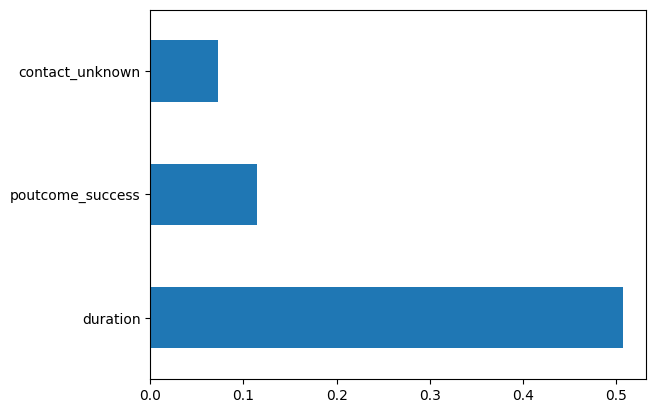

In [49]:
pd.Series(gb.feature_importances_, index=X_train.columns).nlargest(3).plot(kind='barh');

### 5.1 Дополнительная оптимизация. Optuna

Выполним дополнительную оптимизацию гиперпараметров при помощи фреймворка Optuna. 

Для перебора возьмем случайный лес и следующие параметры:
* n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
* max_depth = trial.suggest_int('max_depth', 10, 30, 1);
* min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1).

In [50]:
def optuna_rf(trial):
    n_estimators     = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth        = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    model = RandomForestClassifier(
        n_estimators     = n_estimators,
        max_depth        = max_depth,
        min_samples_leaf = min_samples_leaf,
        random_state     = RANDOM_STATE)

    model.fit(X_train_scaled, y_train)

    score = f1_score(y_test, model.predict(X_test_scaled))
    # score = cross_val_score(model, X, y, cv=CV, scoring="f1", n_jobs=-1).mean()

    return score

In [51]:
study = optuna.create_study(
    study_name = "RandomForestClassifier", 
    direction  = 'maximize'
)

study.optimize(
    optuna_rf, 
    n_trials = 200, 
    n_jobs   = -1
)

study.best_params, study.best_value

[I 2023-10-26 23:46:10,070] A new study created in memory with name: RandomForestClassifier
[I 2023-10-26 23:46:15,047] Trial 1 finished with value: 0.8168035375868604 and parameters: {'n_estimators': 137, 'max_depth': 16, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8168035375868604.
[I 2023-10-26 23:46:16,158] Trial 3 finished with value: 0.8124801018783827 and parameters: {'n_estimators': 188, 'max_depth': 11, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8168035375868604.
[I 2023-10-26 23:46:17,354] Trial 0 finished with value: 0.8195275590551181 and parameters: {'n_estimators': 171, 'max_depth': 29, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8195275590551181.
[I 2023-10-26 23:46:19,502] Trial 2 finished with value: 0.8180669614655718 and parameters: {'n_estimators': 192, 'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8195275590551181.
[I 2023-10-26 23:46:20,120] Trial 5 finished with value: 0.8163779527559054 and parameters: {'n_

({'n_estimators': 167, 'max_depth': 22, 'min_samples_leaf': 3},
 0.824677368586717)

Применим оптимальные параметры к модели и посчитаем метрики

In [52]:
model = RandomForestClassifier(**study.best_params, random_state=RANDOM_STATE)
model.fit(X_train_scaled, y_train)

y_train_pred_rf = model.predict(X_train_scaled)
# print(f'RFC F1_score на обучающей выборке: {f1_score(y_train, y_train_pred_rf).round(2)}')

y_test_pred_rf = model.predict(X_test_scaled)
print(f'RFC F1 Score на тестовой выборке: {f1_score(y_test, y_test_pred_rf).round(2)}')
print(f'RFC Accuracy на тестовой выборке: {accuracy_score(y_test, y_test_pred_rf).round(2)}')

print(f"Наилучшие значения гиперпараметров {study.best_params}")

RFC F1 Score на тестовой выборке: 0.82
RFC Accuracy на тестовой выборке: 0.83
Наилучшие значения гиперпараметров {'n_estimators': 167, 'max_depth': 22, 'min_samples_leaf': 3}
